# Project Title: 
Store Sales - Time Series Forecasting

# Business Understanding

## 1. Introduction
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.


### 1.1. Objectives
Understand the data: The first objective is to gain insights into the store sales data, including store-specific information, product families, promotions, and sales numbers. This understanding will enable the company to make informed business decisions.

Predict store sales: Develop a reliable time series forecasting model that accurately predicts the unit sales for different product families at various Favorita stores. This will help the company optimize inventory management, plan promotions, and improve overall sales performance.

### 1.2. Methodology
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this methodology, we aim to provide valuable insights to the telecom company and develop a reliable predictive model for customer churn.

# Setup

## Installations

In [108]:
# %pip install pyodbc

## Importation

In [109]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Other Packages
import warnings

warnings.filterwarnings("ignore")

## Data Loading

### Loading the data from SQL database

In [110]:
# Load environment variables from the .env file into a dictionary
environment_vars = dotenv_values('.env')

# Get the credential values from the '.env' file 
server = environment_vars.get("SERVER")
database = environment_vars.get("DATABASE")
username = environment_vars.get("USERNAME")
password = environment_vars.get("PASSWORD")

# Create the connection string using the ODBC driver format
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Establish the connection using the connection string
conn = pyodbc.connect(conn_str)

In [111]:
# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, conn)

# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_events_df = pd.read_sql(query2, conn)

# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, conn)

In [112]:
# Close connection
conn.close()

In [113]:
# Display the dataframe
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [114]:
# Display the dataframe
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [115]:
# Display the dataframe
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Loading the Train and Test Datasets

#### Train Dataset

In [116]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


#### Test Dataset

In [117]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Loading the Transactions Dataset

In [118]:
transactions_df = pd.read_csv("transactions.csv")
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Questions and Hypothesis

## Hypothesis

The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Null Hypothesis (H0): The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

## Questions
1. Is the train dataset complete, including all the required dates?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake have an impact on sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices, and holidays?
6. What analysis can be derived from the date and its extractable features?
7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Key Analytical Questions:

1. How does the presence of promotional activities affect store sales?

2. What is the relationship between oil prices and store sales?

3. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?

4. How does the historical sales trend vary across different stores and product families?

    a. Are there certain product families types that exhibit higher sales performance?
    b. Are there any notable correlations between variables such as store size, location, or cluster, and sales performance?

5. Is there any seasonality or trend (recurring patterns) in the store sales data?

6. Can we identify any specific time periods or events that led to significant changes in store sales?

7. How does store transaction volume (number of transactions) correlate with sales? Are there any insights to be gained from transaction data?

9. Does store sales vary based on the day of the week or month of the year?

# Exploratory Data Analysis (EDA), Data Preprocessing & Cleaning 

## Understanding the datasets

An in-depth exploration of the datasets is presented to gain insights into the available variables,their distributions and relationships. This step will provide an initial undertanding of the datasets to identify any data quality issues that will inform the cleaning and pre-processing.

### i. Shape of The Datasets

In [119]:
# Print out the shapes of the train and test datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Test Datasets: {test_df.shape}")

Train Dataset: (3000888, 6)
Test Datasets: (28512, 5)



The train dataset contains 3,000,888 rows and 6 columns while the test dataset contains 28,512 rows and 5 columns.

The train dataset is significantly larger than the test dataset in terms of the number of rows. This is expected, as the train dataset is usually larger to provide sufficient data for model training.

In [120]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {transactions_df.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


The Holiday Events dataset contains 350 rows and 6 columns. This dataset provides information about various holidays and events.

The Oil dataset consists of 1,218 rows and 2 columns. This dataset includes information about the daily price of oil.

The Stores dataset contains 54 rows and 5 columns. This dataset provides details about different stores, such as their locations, types, and clusters.

The Transactions dataset contains 83,488 rows and 3 columns. This dataset contains information about the number of transactions made at each store on specific dates.

### ii. Column Information of The Datasets

In [121]:
# Get the column information of each dataset
# Function to display column information of the datasets
def show_column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('==='*14)

In [122]:
# Column information of the train and test columns
show_column_info('Train', train_df)
print()
show_column_info('Test', test_df)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None


- The train dataset contains 3,000,888 entries and 6 columns: 'id', 'date', 'store_nbr', 'family', 'sales', and 'onpromotion'.
- The test dataset contains 28,512 entries and 5 columns: 'id', 'date', 'store_nbr', 'family', and 'onpromotion'.
- The "date" column in both datasets of type object. It needs to be converted to a datetime data type for further analysis.
- As expected, the test dataset does not have the "sales" column. This column is not needed because 'sales' is the variable we want to predict. The goal is to use the trained model to predict or forecast the sales in the test data based on the other available features.

In [123]:
# Column information of the other datasets
show_column_info('Holiday events', holidays_events_df)
print()
show_column_info('Oil', oil_df)
print()
show_column_info('Stores', stores_df)
print()
show_column_info('Transactions', transactions_df)

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

Data types for the Oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

Data types for the Stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Dat

##### The Holiday Events Dataset:
- The dataset contains 350 entries and 6 columns: 'date', 'type', 'locale', 'locale_name', 'description', and 'transferred'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

##### The Oil Dataset:
- The dataset contains 1,218 entries has 2 columns: 'date' and 'dcoilwtico'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.
- The 'dcoilwtico' column has 1,175 non-null values, indicating that there are some missing values in this column.

##### The Stores dataset:
- The dataset contains 54 entries and 5 columns: 'store_nbr', 'city', 'state', 'type', and 'cluster'.

##### The Transactions dataset:
- The dataset contains 83,488 entries and 3 columns: 'date', 'store_nbr', and 'transactions'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

### iii. Transforming the 'date' column to datetime format

In [124]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])

# Test dataset
test_df['date'] = pd.to_datetime(test_df['date'])

# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Transactions dataset
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [125]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train_df['date'].dtype)
print("Test dataset:", test_df['date'].dtype)
print("Holiday Events dataset:", holidays_events_df['date'].dtype)
print("Oil dataset:", oil_df['date'].dtype)
print("Transactions dataset:", transactions_df['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


The 'date' columns in all datasets are formatted correctly.

### iv. Summary statistics of the datasets

In [126]:
# Checking for the summary statistics of the datasets 
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02

Test dataset summary statistics:
---------------------------------------------
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.0

### v. Checking for Missing Values in The Datasets

In [127]:
# Check for missing values in the datasets
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



Of all the columns in the different datasets, it is only the 'dcoilwtico' (daily crude oil prices) column in the Oil dataset which has missing values. The column has 43 missing values.

#### Handling the Missing Values in the 'dcoilwtico' (daily crude oil prices) column of the Oil Dataset.

In [128]:
# Visualizing the 'dcoilwtico' column to Identify a Strategy for Handling Missing Values
fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

##### Fill missing values in the 'dcoilwtico' column using backfill strategy

In [129]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='backfill')

In [130]:
# Check for missing values after handling
missing_values_after = oil_df['dcoilwtico'].isnull().sum()
missing_values_after

0

In [131]:
# Visualizing the 'dcoilwtico' column to confirm proper handling of Missing Values
fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

The missing values in the 'dcoilwitco' column have been handled and are consistent.

 ### vi. Checking for the completeness of the 'date' column in the Train Dataset

In [132]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [133]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_df = pd.concat([train_df, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_df.sort_values('date', inplace=True)

Confirm if the train dataset is complete

In [134]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


The missing dates have been handled successfully.

### vi. Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [135]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = train_df.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions_df, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events_df, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_df = merged_df3.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


The use of an inner merge in this time series forecasting project for corporation Favorita helps to ensure data consistency, avoid missing values, and focus on the relevant data for accurate predictions.

An inner merge type retains only the rows with matching values in the specified columns. In the context of time series forecasting, it allows us to merge datasets based on a common time index or timestamp. By performing an inner merge, we ensure that only the rows with corresponding timestamps in both datasets are included in the merged result. This is important for time series forecasting because you want to align the data from different sources based on their timestamps to build a consistent and accurate forecasting model.

With an inner merge, you eliminate any non-matching timestamps, which may not be useful for forecasting and could introduce inconsistencies in the data. By focusing on the intersection of the datasets, we can create a merged dataset that contains the necessary information for accurate time series forecasting.

In [136]:
# Check the column information of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

The merged dataset after merging the train dataset with additional datasets contains 322,047 rows and 16 columns.
Two columns have been renamed as a result of the merging, type_x and type_y.

In [137]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_df['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_df['type_y'].unique())

Unique values of 'type_x':
['D' 'E' 'C' 'A' 'B']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


The merged dataset consists of 322,047 non-null observations.
Two columns have been renamed as a result of the merging, type_x and type_y.

- The type_x column represents the store type.
- The type_y column represents the holiday type.

In [138]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [139]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,322047.0,1.682979e+06,786249.257767,561.000000,1.010616e+06,1842406.00,2.209556e+06,3.000887e+06
store_nbr,322047.0,2.699467e+01,15.595174,1.000000,1.300000e+01,27.00,4.000000e+01,5.400000e+01
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.000000e+00,19.00,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.000000e+00,0.00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.000000e+00,9.00,1.300000e+01,1.700000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1.030000e+03,1409.00,2.148000e+03,8.359000e+03
dcoilwtico,322047.0,6.363638e+01,24.855753,27.959999,4.488000e+01,51.98,9.409000e+01,1.079500e+02


### viii. Checking for Missing Values in The Datasets

In [140]:
# Check for missing values in the merged datasets
missing_values = merged_df.isnull().sum()
missing_values

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

The merged dataset has no missing values.

### ix. Checking for Duplicate Values in The Datasets

In [141]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_df.duplicated()
duplicate_rows_merged.sum()

0

In [142]:
# Check for duplicate values in the test dataset
duplicate_rows_test = test_df.duplicated()
duplicate_rows_test.sum()

0

There are no duplicates in the merged and test datasets

### x. Save the merged dataset in a new CSV file to be used in PowerBI Visualization

In [143]:
merged_df.to_csv('Visualization_Data.csv', index=False)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [144]:
# Create A Copy of The Merged Dataset
merged_df_copy = merged_df.copy()
merged_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   store_type    322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  holiday_type  322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

## Univariate, Multivariate and Bivariate Analysis

### i. Univariate Analysis

#### a. Distribution of the 'sales' variable:

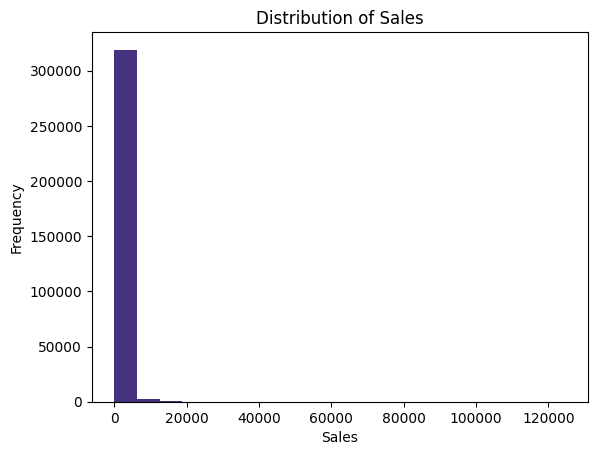

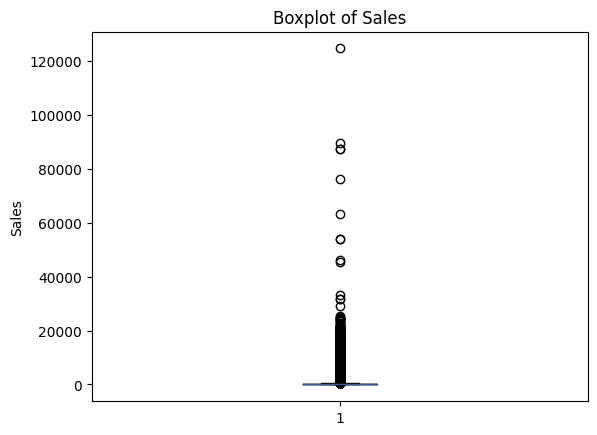

In [145]:
# Histogram
plt.hist(merged_df['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged_df['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

The histogram and boxplot of the 'sales' variable provide insights into its distribution. The histogram shows the frequency distribution of sales values. It reveals that the majority of sales fall within a specific range, represented by the peak in the histogram. However, there are also instances of higher sales values, leading to a right-skewed distribution. This skewness suggests that there are relatively fewer occurrences of very high sales, while the majority of sales are concentrated around lower values. The boxplot further confirms the presence of outliers in the data, as indicated by the points beyond the whiskers.

#### b. distribution of the 'transactions' variable:

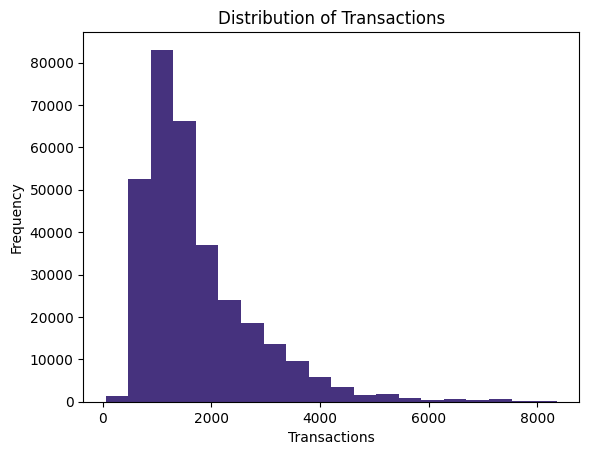

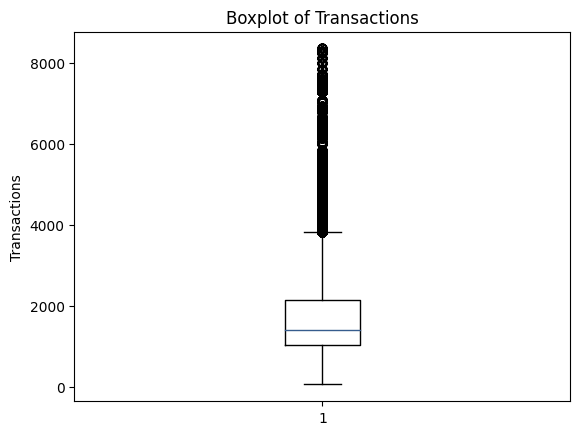

In [146]:
# Histogram
plt.hist(merged_df['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()

# Boxplot
plt.boxplot(merged_df['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.show()

This histogram provides insights into the distribution of transactions in the dataset. The shape of the histogram indicates that the majority of transactions fall into a specific range, which is evident from the high frequency observed on the left side of the histogram. As the transactions increase, the frequency gradually decreases, forming a right-skewed distribution. This suggests that there are relatively fewer instances of high transaction volumes. Overall, the histogram highlights the presence of a cluster of transactions with a lower frequency, indicating a pattern in the data.

#### c. Distribution of the 'Daily Oil Price' variable:

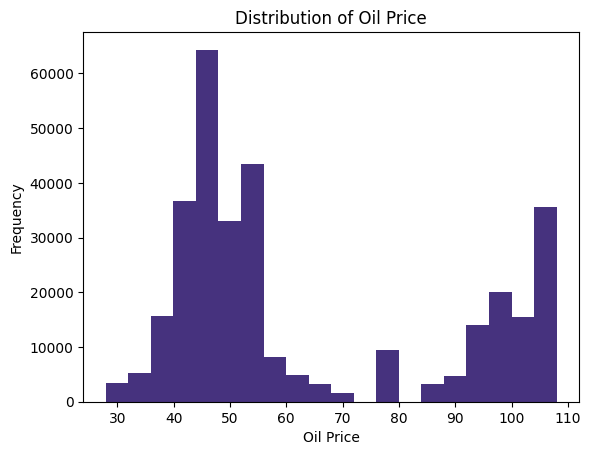

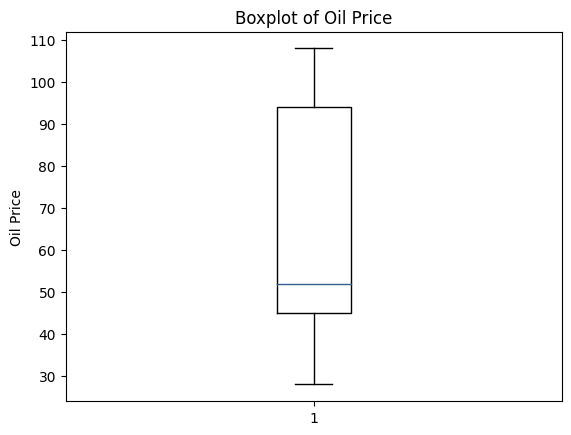

In [147]:
# Histogram
plt.hist(merged_df['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

# Boxplot
plt.boxplot(merged_df['dcoilwtico'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')
plt.show()

The histogram and boxplot of the 'dcoilwtico' variable reveal insights into its distribution. The histogram displays the frequency distribution of oil prices, indicating the number of occurrences for each price range.

### ii. Bivariate Analysis

#### a. Trend of sales over time.

In [148]:
# Group the data by date and calculate the total sales
daily_sales = merged_df.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

The plot shows the trend of sales over time. From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

#### b. Trend of Daily Crude oil Prices Over Time

In [149]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

We can see that there is a trend in the in the oil prices over time. We see that oil prices suffered a collapse towards the end of 2014 and have not recovered. In fact despite some volatility, oil prices are at the same level as they were in the beginning of 2015. As a result of this we may see a significant shift in store sales around late 2014. Looking at the unit sales data, this is not readily apparent. Although sales do appear to drop off in the early part of 2015, in late 2014 they are rising. Also, to add oil price drop doesn't seems to have any impact on the sales, as it was seen from the sales plot, there was no relation between oil price dropping on the sales, so we can say that this feature or data is of no importance to us and will not be considered during modelling.

#### c. Total Count of Sales by Store Type

In [150]:
# Set the color palette to "viridis"
sns.set_palette("viridis")

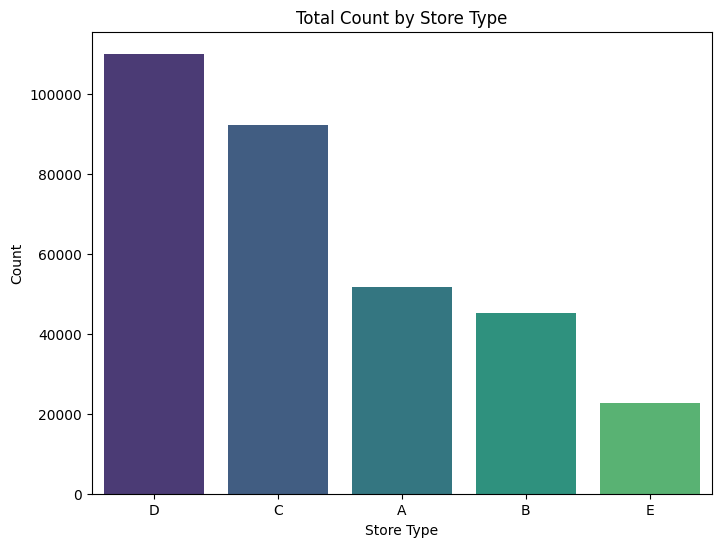

In [151]:
# Calculate the total count and total sales per store type
store_type_counts = merged_df['store_type'].value_counts()
store_type_sales = merged_df.groupby('store_type')['sales'].sum()

# Create a bar plot with "viridis" color palette for total count
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.show()

The analysis of the total count of sales by store type provides insights into the sales performance and customer demand across different store types. Store Type D stands out with the highest count of sales, suggesting a strong customer base and popularity of products offered. Store Type C follows with a relatively lower count of sales, indicating a significant customer base as well. On the other hand, Store Types A, B, and E have lower counts, suggesting potential areas for improvement or the need to address competition.

#### d. Total Amount in Sales by Store Type

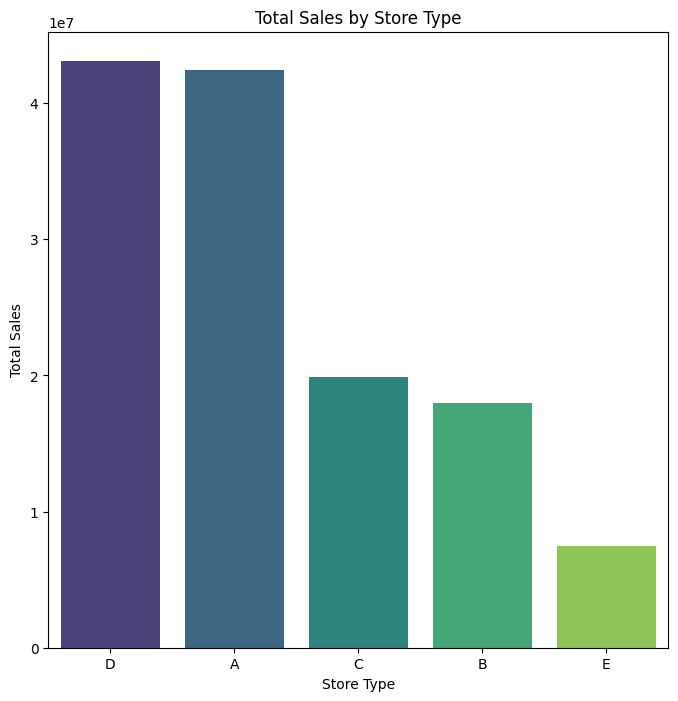

In [152]:
# Order the store types by total sales
store_type_sales = store_type_sales.sort_values(ascending=False)

# Create a bar plot with "viridis" color palette for total sales
plt.figure(figsize=(8, 8))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, order=store_type_sales.index, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Type')
plt.show()

The total sales amount varies across different store types. Store Type D has the highest total sales, indicating its significant contribution to the overall sales. Store Type A follows closely behind, demonstrating its substantial sales performance. Store Type C ranks third in terms of total sales, while Store Type B and Store Type E have lower sales amounts. Understanding the variations in sales by store type helps identify the key drivers of revenue and highlights the importance of certain store types in driving overall sales.

#### e. Average Sales by City

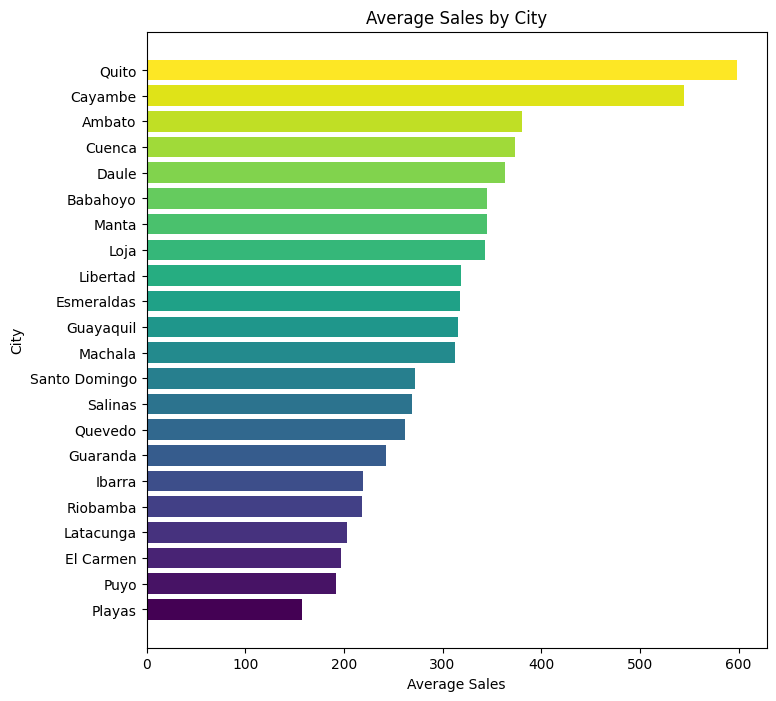

In [153]:
# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

Quito has the highest number of stores, significantly surpassing other cities. Cayambe is the second most populated city in terms of stores followed by Ambato, Daule and Loja. Some cities have a moderate number of stores while others have a lower number of stores. Puyo has the lowest number of sales.

#### f. Average Sales by State

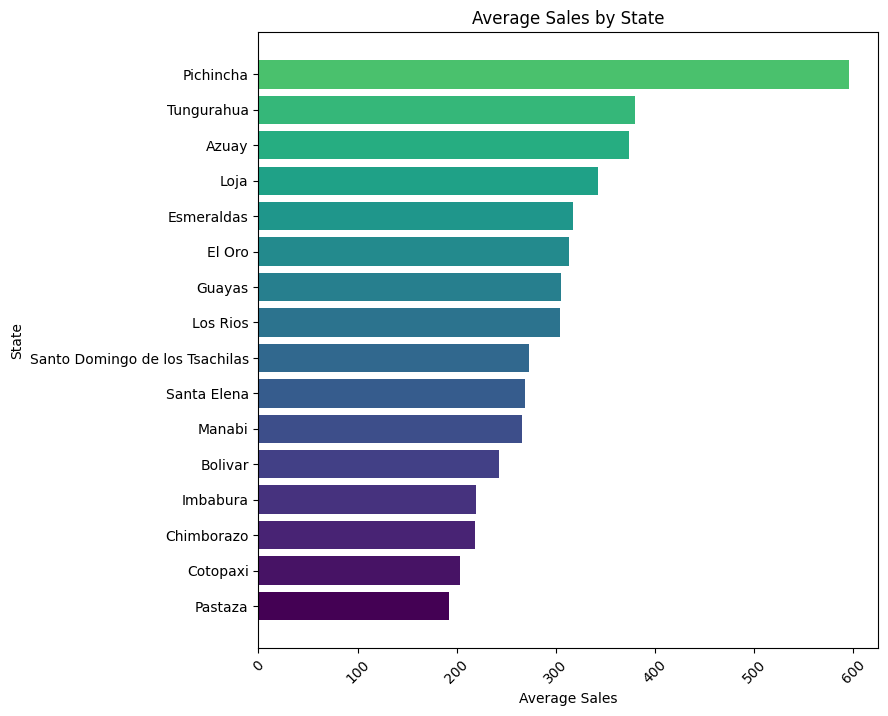

In [154]:
# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

Pichincha has the highest number of stores, primarily due to the presence of Quito, the capital city. Guayas is the second most populous state in terms of stores, with Guayaquil being a major city. Santo Domingo de los Tsachilas, Azuay, Manabi, Cotopaxi, Tungurahua, Los Rios, El Oro, Chimborazo, Imbabura, Bolivar, Pastaza, Santa Elena, and Loja have a moderate number of stores.

#### g. Relationship between sales and transactions.

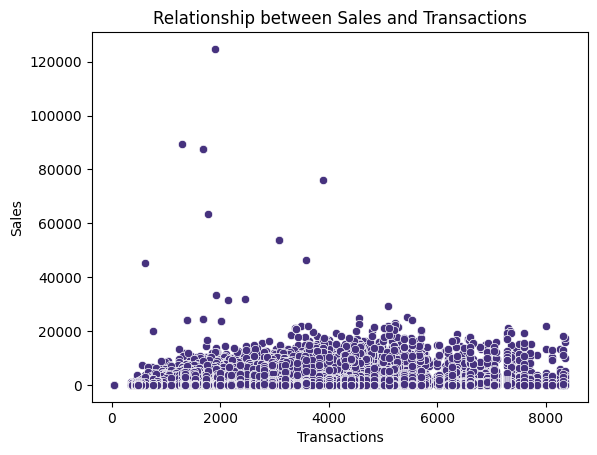

In [155]:
sns.scatterplot(x='transactions', y='sales', data=merged_df)
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.title('Relationship between Sales and Transactions')
plt.show()

The scatter plot visualizes the relationship between sales and transactions in the dataset. Each data point represents a specific instance with corresponding sales and transaction values. Here are the key insights drawn from the scatter plot:

Clustered Data Points: The majority of data points cluster in the lower sales region, forming a specific concentration. This clustering suggests that there are certain transaction volumes that are consistently associated with particular sales levels. This concentration may indicate a common sales pattern or trend that occurs at specific transaction levels.

Outliers: Several data points deviate from the main cluster and are located at higher sales levels for relatively lower transaction volumes or vice versa. These outliers represent exceptional instances where sales are significantly different from what is typically observed for a given number of transactions. Identifying and understanding these outliers can provide valuable insights into unusual sales scenarios or exceptional business activities.

In summary, the scatter plot provides valuable insights into the relationship between sales and transactions. The clustering of data points around specific sales and transaction levels indicates the presence of common patterns. Additionally, outliers represent exceptional cases that warrant further investigation to understand the factors influencing sales and transactions in unique instances. This analysis can help businesses make informed decisions and devise effective strategies to improve sales performance.

### iii. Multivariate Analysis

#### a. Correlation matrix of numerical variables

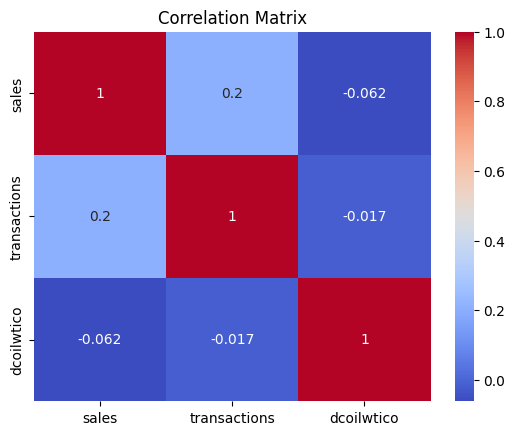

In [156]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_df[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlation values range from -1 to 1, where -1 represents a perfect negative correlation, 1 represents a perfect positive correlation, and 0 represents no correlation. The table helps us understand how the variables are related to each other, providing valuable insights into their interactions. In this correlation matrix, we can see the correlations between different variables:

- Sales and Transactions:
There is a weak positive correlation of approximately 0.200 between "Sales" and "Transactions." This suggests that there is a slight positive relationship between the number of transactions and the sales. It implies that when the number of transactions increases, there is a tendency for sales to increase as well, although the correlation is not very strong.

- Sales and Dcoilwito (Oil Prices):
There is a weak negative correlation of approximately -0.062 between "Sales" and "Dcoilwito" (Oil Prices). This indicates a slight negative relationship between sales and oil prices. It suggests that as oil prices increase, there is a tendency for sales to decrease slightly, though the correlation is not significant.

- Transactions and Dcoilwito (Oil Prices):
There is a very weak negative correlation of approximately -0.017 between "Transactions" and "Dcoilwito" (Oil Prices). This suggests that there is almost no relationship between the number of transactions and oil prices. It indicates that fluctuations in oil prices do not have a significant impact on the number of transactions.

Overall, the correlation values are relatively low, indicating that the relationships between these variables are not very strong. Other factors not considered in this correlation matrix may also influence sales, transactions, and oil prices. It's essential to explore additional factors to gain a more comprehensive understanding of their impact on sales and transactions.

#### b. Scatter Plot Marrix of numerical Variables

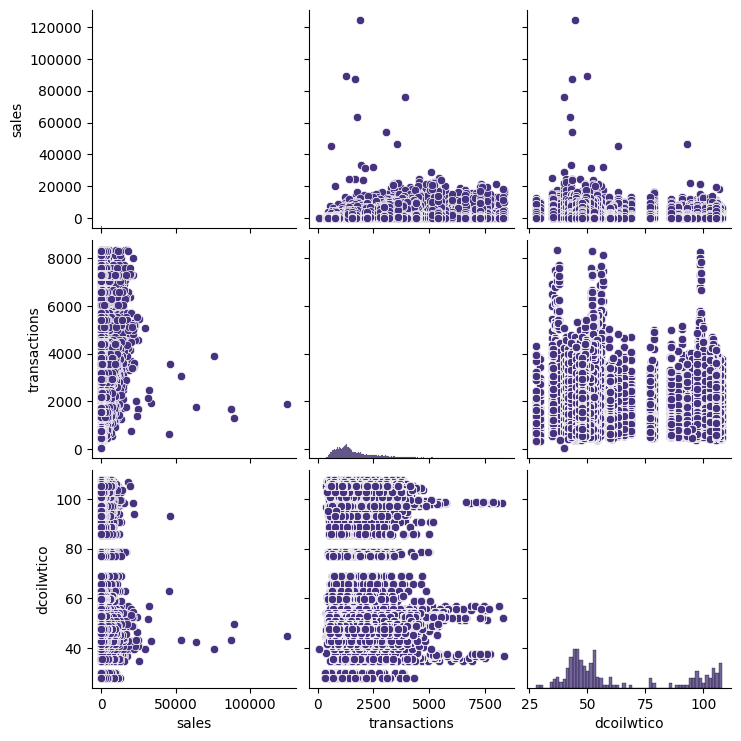

In [157]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_df[numerical_vars])
plt.show()

The observations of the scatter plot matrix corroborate the observations from the correlation matrix.

## Stationarity Test

Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. In this case, the ADF test was conducted on the 'sales' data from the 'merged_df' dataset. To perform the stationarity test, we will use the Augmented Dickey-Fuller (ADF) test commonly used to check for stationarity in a time series.

- Null hypothesis (H0): The sales data is non-stationary.
- Alternative hypothesis (H1): The sales data is stationary. 

In [158]:
# Statistical Test of the 'sales' column in the merged_df using Adfuller
sales_data = merged_df['sales']

# Perform ADF test
result = adfuller(sales_data)

# Extract the test statistics and p-value from the result
test_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the test statistics and critical values
print(f"ADF Test Statistics: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")

ADF Test Statistics: -43.834623712800614
P-value: 0.0
Critical Values:
   1%: -3.4303703113855613
   5%: -2.8615489773824025
   10%: -2.566774778334627
Reject the null hypothesis: The sales data is stationary.


Based on the ADF test, the test statistics (-43.83) is significantly lower than the critical values at all confidence levels (1%, 5%, and 10%). Additionally, the p-value is 0.0, which is lower than the significance level of 0.05.

Since the p-value is less than 0.05, we reject the null hypothesis, indicating that the sales data is stationary. The test results suggest that the 'sales' column exhibits stationarity, which means the data has a constant mean and variance over time. This property is essential for time-series analysis and modeling, as it helps to ensure reliable forecasting and prediction of future sales trends.

## Hypothesis Testing and Answering Key Analytical Questions

### Hypothesis Testing

Null Hypothesis (H0): The promotional activities have a significant impact on store sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales for Corporation Favorita.

In [159]:
# Extract the relevant variables for the hypothesis test
promo_sales = merged_df[merged_df['onpromotion'] == 1]['sales']
non_promo_sales = merged_df[merged_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)


from scipy.stats import ttest_ind

# Extract the relevant variables for the hypothesis test
promo_sales = merged_df[merged_df['onpromotion'] == 1]['sales']
non_promo_sales = merged_df[merged_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.")
print("Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on store sales at Corporation Favorita.")


Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.
Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.
--------------------------------------------------
Test Statistic: 68.21684266478505
P-value: 0.0
Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.


Based on the hypothesis test, we obtained a very low p-value of 0.0. This indicates strong evidence to reject the null hypothesis. Therefore, we can conclude that promotional activities have a significant impact on store sales for Corporation Favorita. The test statistic of 68.22 also suggests a substantial difference in sales between promotional and non-promotional periods. These results support the notion that promotional activities play a crucial role in driving store sales.


### Answering Questions

#### 1. Is the train dataset complete (has all the required dates)?

In [160]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


#### 2. Which dates have the lowest and highest sales for each year?

In [161]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year

lowest_sales_dates = merged_df.groupby('year')['date'].min()
highest_sales_dates = merged_df.groupby('year')['date'].max()

print("Dates with the lowest sales for each year:\n", lowest_sales_dates)
print("="*50)
print("Dates with the highest sales for each year:\n", highest_sales_dates)

Dates with the lowest sales for each year:
 year
2013   2013-01-01
2014   2014-01-01
2015   2015-01-01
2016   2016-02-08
2017   2017-01-02
Name: date, dtype: datetime64[ns]
Dates with the highest sales for each year:
 year
2013   2013-12-31
2014   2014-12-31
2015   2015-12-31
2016   2016-12-26
2017   2017-08-15
Name: date, dtype: datetime64[ns]


#### 3. Analyze the impact of the earthquake on sales

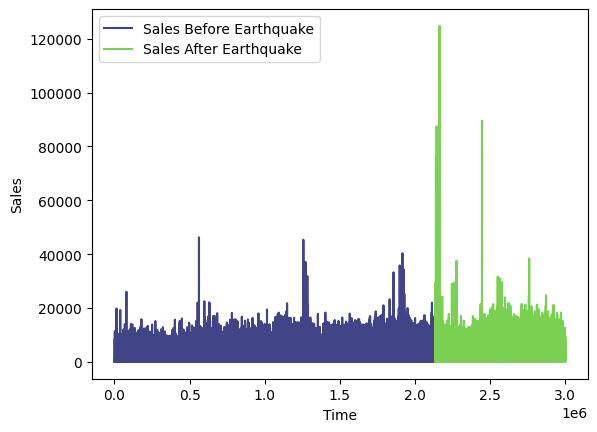

In [162]:
# Assign the variable earthquake_date to the date the earthquake took place (April 16, 2016)
earthquake_date = pd.to_datetime('2016-04-16')

# Filter the sales data before and after the earthquake
sales_before_earthquake = train_df[train_df['date'] < earthquake_date]['sales']
sales_after_earthquake = train_df[train_df['date'] > earthquake_date]['sales']

# Set the colormap to viridis
colormap = cm.get_cmap('viridis')

# Plot the sales before and after the earthquake
plt.plot(sales_before_earthquake, color=colormap(0.2), label='Sales Before Earthquake')
plt.plot(sales_after_earthquake, color=colormap(0.8), label='Sales After Earthquake')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

There was a surge in sales after the eathquake.

#### 4. Determine if certain groups of stores sell more products

In [163]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = merged_df.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = merged_df.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

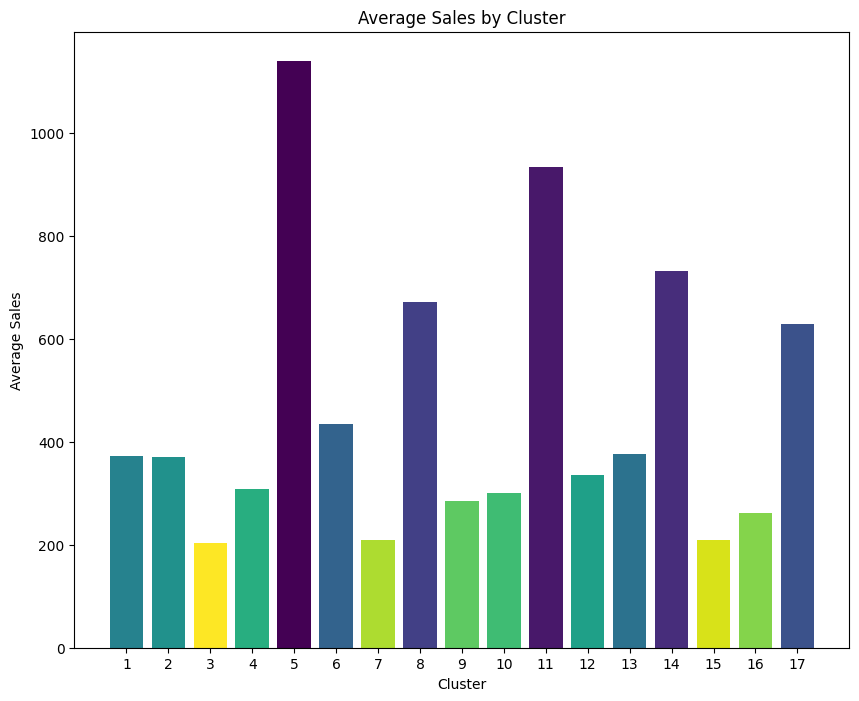

In [164]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

The cluster with the highest number of stores is Cluster 5, followed by Clusters 14, 8, 11 and 12. These clusters have a significantly larger number of stores compared to the others.

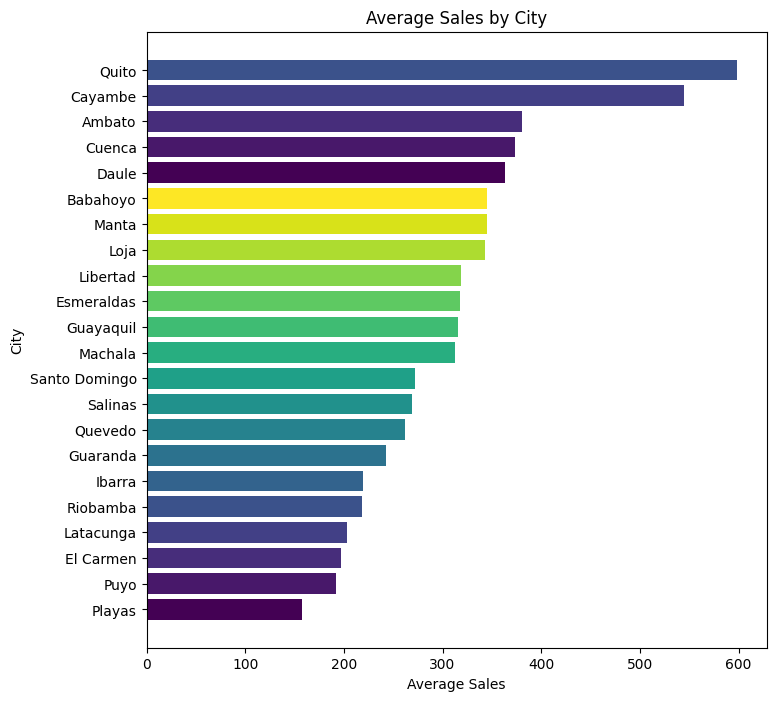

In [165]:
# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

Quito has the highest number of stores, significantly surpassing other cities. Cayambe is the second most populated city in terms of stores followed by Ambato, Daule and Loja. Some cities have a moderate number of stores while others have a lower number of stores. Puyo has the lowest number of sales.

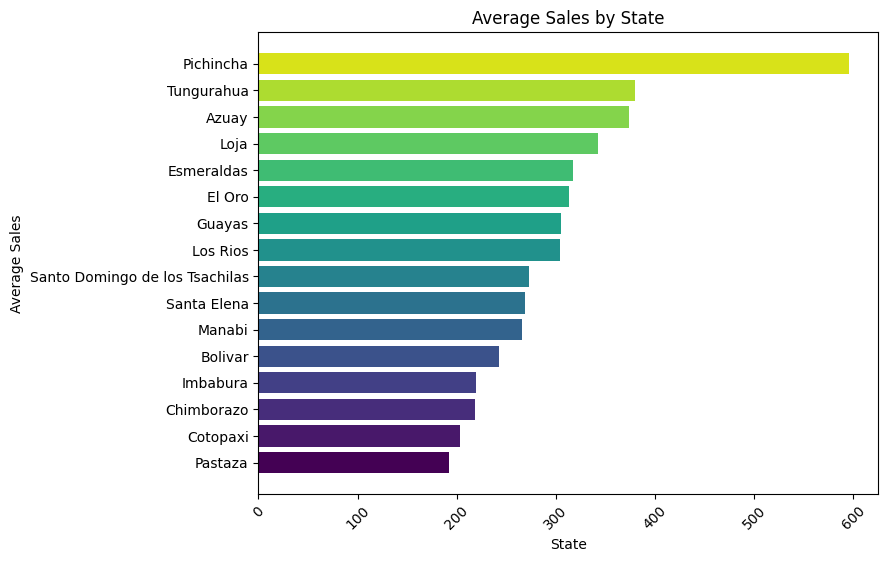

In [166]:
# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 6))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

Pichincha has the highest number of stores, primarily due to the presence of Quito, the capital city.
Guayas is the second most populous state in terms of stores, with Guayaquil being a major city.
Santo Domingo de los Tsachilas, Azuay, Manabi, Cotopaxi, Tungurahua, Los Rios, El Oro, Chimborazo, Imbabura, Bolivar, Pastaza, Santa Elena, and Loja have a moderate number of stores.

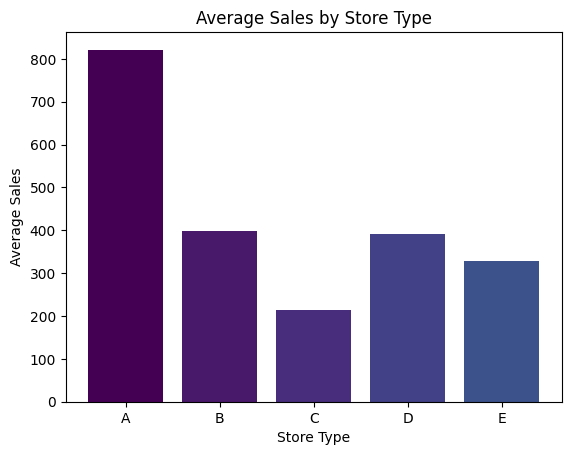

In [167]:
# Plot the average sales by store type
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

The store type with the highest average sales is type A followed by Type D. Store Type C has the lowest average sales.

#### 5. Are sales affected by promotions, oil prices and holidays?

In [168]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = merged_df['sales'].corr(merged_df['onpromotion'])
corr_sales_oil = merged_df['sales'].corr(merged_df['dcoilwtico'])
corr_sales_holidays = merged_df['sales'].corr(merged_df['holiday_type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.41802891972423967
Correlation between Sales and Oil Prices: -0.06150915261069567
Correlation between Sales and Holidays: -0.03706892930251702


- Promotions:
There is a positive correlation of approximately 0.42 between sales and promotions. This suggests that promotions have a moderate positive impact on sales. When promotions are running, there is an increased likelihood of higher sales.


- Oil Prices:
There is a weak negative correlation of approximately -0.06 between sales and oil prices. This indicates that there is a slight negative relationship between sales and oil prices. However, the correlation is close to zero, suggesting that oil prices have minimal impact on sales.


- Holidays:
There is a very weak negative correlation of approximately -0.04 between sales and holidays. This indicates that there is almost no relationship between sales and holidays. Holidays do not seem to have a significant impact on sales.
These insights suggest that promotions have a relatively stronger influence on sales compared to oil prices and holidays. While promotions positively impact sales, oil prices and holidays show minimal or no relationship with sales.

#### 6. What analysis can we get from the date and its extractable features?

In [169]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy['dayofweek'] = merged_df_copy['date'].dt.weekday
merged_df_copy.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day,dayofweek
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0


#### 2. How does the presence of promotional activities affect store sales?

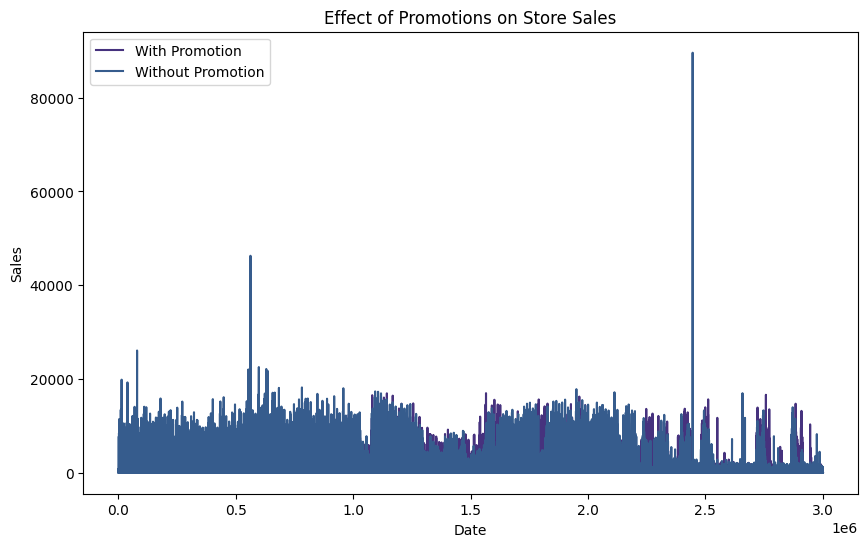

In [170]:
# Filter the data for sales under different promotion conditions
sales_with_promotion = train_df[train_df['onpromotion'] == 1]['sales']
sales_without_promotion = train_df[train_df['onpromotion'] == 0]['sales']

# Create a line plot to compare sales with and without promotions over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_with_promotion, label='With Promotion')
sns.lineplot(data=sales_without_promotion, label='Without Promotion')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Effect of Promotions on Store Sales')
plt.legend()
plt.show()

#### 3. What is the relationship between oil prices and store sales?

In [171]:
# # Create a scatter plot to visualize the relationship between oil prices and store sales
# plt.figure(figsize=(8, 6))
# plt.scatter(merged_df['dcoilwtico'], merged_df['sales'])
# plt.xlabel('Oil Prices')
# plt.ylabel('Sales')
# plt.title('Relationship between Oil Prices and Store Sales')
# plt.show()

#### 4. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?

#### 5. How does the historical sales trend vary across different stores and product families?

a. Are there certain product families types that exhibit higher sales performance? 

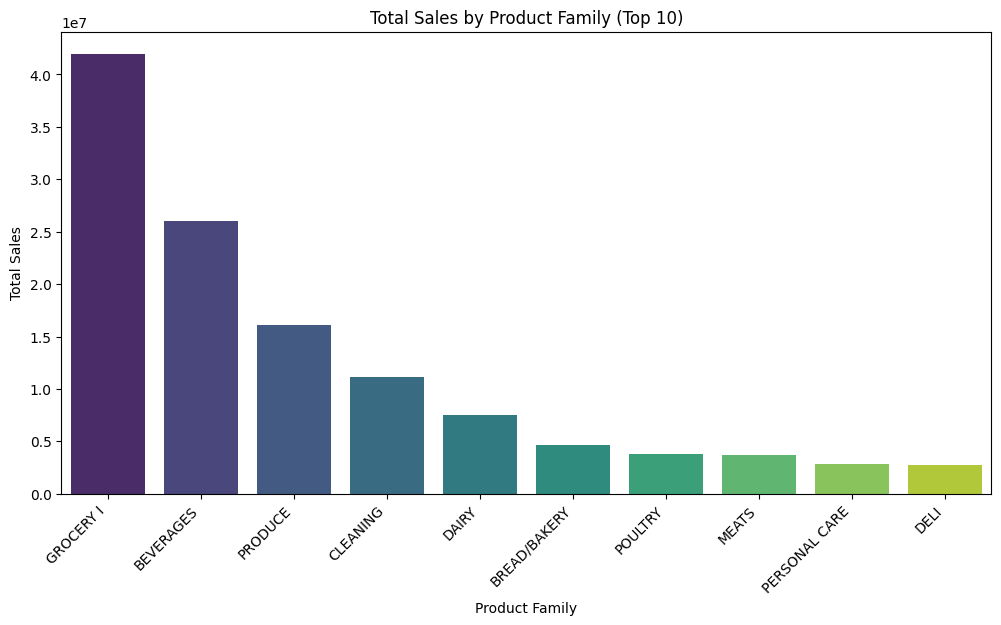

In [172]:
# Group the data by product family and calculate the total sales
family_sales = merged_df.groupby('family')['sales'].sum().sort_values(ascending=False)

# Select the top 10 product families
top_10_families = family_sales.head(10)

# Plot the relationship between product family and sales for the top 10 families
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_families.index, y=top_10_families.values, palette='viridis')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Family (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.show()

The graph illustrates the sales performance of the top 10 product families. Grocery I and beverages exhibit the highest sales, indicating their popularity among customers. Produce and cleaning products also demonstrate significant sales, reflecting the importance of fresh produce and household cleaning supplies. Dairy, bread/bakery, poultry, and meats contribute to overall sales, suggesting the demand for essential food items. Personal care and deli products have relatively lower sales but still play a role in the product mix.

b. Are there any notable correlations between variables such as store number, location, or cluster, and sales performance?

#### 6. Is there any seasonality or trend (recurring patterns) in the store sales data?

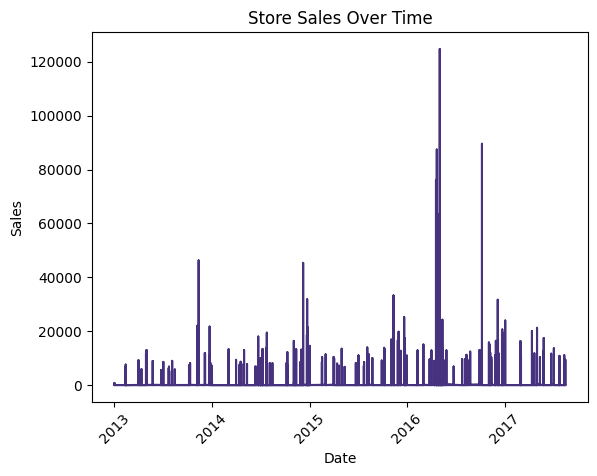

In [173]:
# Create a line plot to visualize the store sales over time
plt.plot(merged_df['date'], merged_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Store Sales Over Time')
plt.xticks(rotation=45)
plt.show()

#### 7. Can we identify any specific time periods or events that led to significant changes in store sales?

#### 8. How does store transaction volume (number of transactions) correlate with sales? Are there any insights to be gained from transaction data?

#### 9. Does store sales vary based on the day of the week or month of the year?

#### 10. How does the sales trend vary across different store numbers?

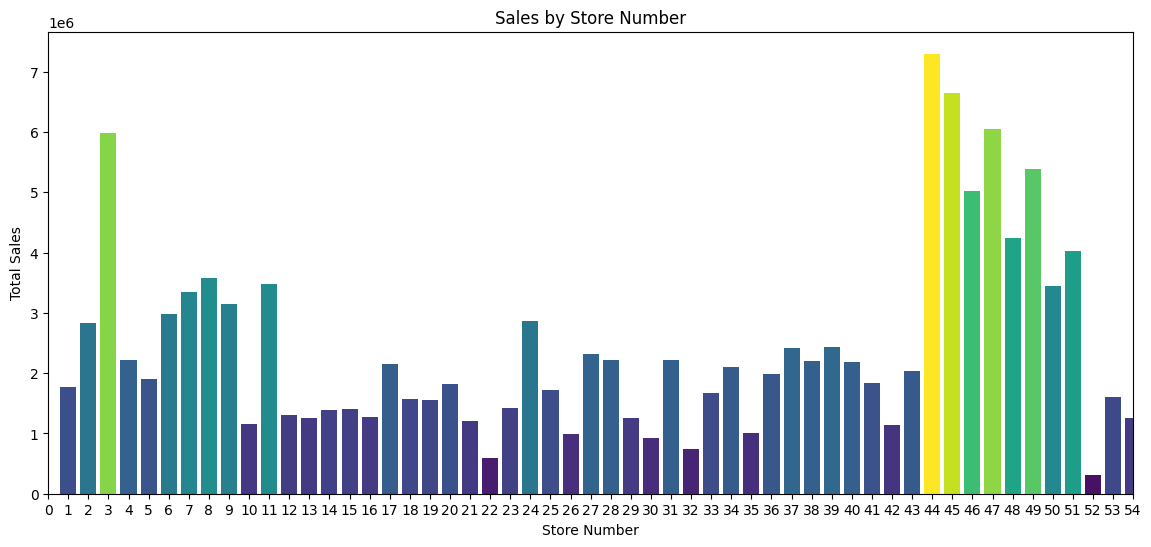

In [174]:
store_sales = merged_df.groupby('store_nbr')['sales'].sum()

plt.figure(figsize=(14, 6))
plt.bar(store_sales.index, store_sales.values, color=cm.viridis(store_sales.values/max(store_sales.values)))
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Sales by Store Number')

# Set the X-axis limits and ticks
plt.xlim(0, 54)
plt.xticks(range(55))

plt.show()

# Feature Enginering

## Extracting Date Components (Day, Month, Year and Day of The Week).

In [175]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day,dayofweek
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0


## Dropping Unneccessary Columns in The Merged and Test Datasets as it is not needed for our analysis

In [176]:
columns_to_drop = ['date','id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_df_copy = merged_df_copy.drop(columns=columns_to_drop)

merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,dayofweek
0,1.0,AUTOMOTIVE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
1,1.0,MAGAZINES,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
3,1.0,LINGERIE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
4,1.0,LAWN AND GARDEN,3.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0


In [177]:
# Drop Unneccessary columns in the test dataset
test_df.drop('id', axis=1, inplace=True)
test_df.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


## Product Categorization Based on Families

In [178]:
unique_families = merged_df_copy['family'].unique()
unique_families

array(['AUTOMOTIVE', 'MAGAZINES', 'LIQUOR,WINE,BEER', 'LINGERIE',
       'LAWN AND GARDEN', 'LADIESWEAR', 'HOME CARE', 'HOME APPLIANCES',
       'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'MEATS', 'GROCERY I', 'EGGS', 'DELI', 'DAIRY',
       'CLEANING', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS', 'BEVERAGES',
       'BEAUTY', 'BABY CARE', 'FROZEN FOODS', 'PERSONAL CARE',
       'PLAYERS AND ELECTRONICS', 'PET SUPPLIES', 'SEAFOOD',
       'SCHOOL AND OFFICE SUPPLIES', 'PRODUCE', 'PREPARED FOODS',
       'POULTRY'], dtype=object)

In [179]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(food_families), 'FOODS', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(home_families), 'HOME', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(clothing_families), 'CLOTHING', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(grocery_families), 'GROCERY', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(stationery_families), 'STATIONERY', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(cleaning_families), 'CLEANING', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(hardware_families), 'HARDWARE', merged_df_copy['family'])

# Print the updated DataFrame
merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,dayofweek
0,1.0,AUTOMOTIVE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
1,1.0,STATIONERY,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
3,1.0,CLOTHING,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
4,1.0,LAWN AND GARDEN,3.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0


## Feature Scaling

In [180]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_df_copy[num_cols] = scaler.fit_transform(merged_df_copy[num_cols])

# Display the updated dataframe
merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,dayofweek
0,1.0,AUTOMOTIVE,-0.325920,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,0
1,1.0,STATIONERY,-0.325920,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,0
2,1.0,"LIQUOR,WINE,BEER",-0.309078,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,0
3,1.0,CLOTHING,-0.325920,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,0
4,1.0,LAWN AND GARDEN,-0.323514,0.0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11,0


## Encoding The Categorical Variables

In [181]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_df_copy[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_df_copy, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,dayofweek,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,1.0,-0.325920,0.0,13,-1.273993,1.342694,2013,2,11,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,-0.325920,0.0,13,-1.273993,1.342694,2013,2,11,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,-0.309078,0.0,13,-1.273993,1.342694,2013,2,11,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,-0.325920,0.0,13,-1.273993,1.342694,2013,2,11,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,-0.323514,0.0,13,-1.273993,1.342694,2013,2,11,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Modeling

## Data Splitting

In [182]:
train_set = merged_df_encoded.loc[merged_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [183]:
train_set.shape

(284889, 51)

In [184]:
eval_set.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,dayofweek,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
284757,1.0,-0.232308,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284758,1.0,-0.325118,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284759,1.0,-0.305870,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284760,1.0,-0.322712,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284761,1.0,-0.322712,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [185]:
eval_set.shape

(37158, 51)

In [186]:
eval_set.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,dayofweek,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
284757,1.0,-0.232308,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284758,1.0,-0.325118,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284759,1.0,-0.305870,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284760,1.0,-0.322712,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284761,1.0,-0.322712,0.0,13,-1.159744,-0.453674,2017,1,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [187]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [188]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

## Model 1. Linear Regression

In [190]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
print(results_lr)


               Model  RMSLE  RMSE  MSE   MAE
0  Linear Regression   0.27  0.84  0.7  0.37


## Model 2. Random Forest Regression

In [192]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
print(results_rf)

           Model  RMSLE  RMSE   MSE   MAE
0  Random Forest   0.22  0.71  0.51  0.24


## Model 3. Gradient Boosting Regression

In [193]:
# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)

# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [gb_mae]}).round(2)

# Print the results_gb dataframe
print(results_gb)

               Model  RMSLE  RMSE   MSE   MAE
0  Gradient Boosting   0.23  0.64  0.41  0.28


## Model 4. ARIMA

In [195]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima

,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,0.45,1.09,1.19,0.5


## Model 5. SARIMA

In [202]:
# Set the order and seasonal order parameters
# Seasonal autoregressive order
P = 0  
# Seasonal differencing order
D = 0  
# Seasonal moving average order
Q = 0  
# Number of time steps in each season (chosen based on months with 31 days)
s = 31  

# Create an instance of the SARIMA model
sarima_model = SARIMAX(endog=y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_fit = sarima_model.fit()

# Make predictions on the evaluation data
sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval)

# Calculate metrics
sarima_mse = mean_squared_error(y_eval, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
results_sarima = pd.DataFrame({'Model': ['SARIMA'],
                                'RMSLE': [sarima_rmsle],
                                'RMSE': [sarima_rmse],
                                'MSE': [sarima_mse],
                                'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
print(results_sarima)

In [ ]:
# Append all results to the results dataframe
results_df = results_df.append(results_lr)
results_df = results_df.append(results_rf)
results_df = results_df.append(results_arima)
results_df = results_df.append(results_arima)

# Print the Final Results dataframe
results_df